VesselMNIST3D Test Training Notebook - WITH CUSTOM 3D AUGMENTATION
Complete implementation with working 3D data augmentation

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from medmnist import VesselMNIST3D

2025-12-11 16:31:27.608050: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CUSTOM 3D AUGMENTATION LAYER


In [2]:
class Augment3D(layers.Layer):
    """Custom 3D data augmentation layer for volumetric medical images"""
    
    def __init__(self, 
                 flip_prob=0.5,
                 rotate_prob=0.3,
                 brightness_delta=0.1,
                 contrast_range=(0.9, 1.1),
                 **kwargs):
        super().__init__(**kwargs)
        self.flip_prob = flip_prob
        self.rotate_prob = rotate_prob
        self.brightness_delta = brightness_delta
        self.contrast_range = contrast_range
    
    def call(self, images, training=None):
        # Default to False if training is not specified
        if training is None:
            training = False
        
        # Only augment during training
        if not training:
            return images
        
        x = images
        
        # Random flips along different axes (depth, height, width)
        # Each flip is independent with flip_prob
        x = tf.cond(
            tf.random.uniform([]) < self.flip_prob,
            lambda: tf.reverse(x, axis=[1]),  # Flip along depth
            lambda: x
        )
        
        x = tf.cond(
            tf.random.uniform([]) < self.flip_prob,
            lambda: tf.reverse(x, axis=[2]),  # Flip along height
            lambda: x
        )
        
        x = tf.cond(
            tf.random.uniform([]) < self.flip_prob,
            lambda: tf.reverse(x, axis=[3]),  # Flip along width
            lambda: x
        )
        
        # Random 90-degree rotations in the XY plane (around Z axis)
        # Use tf.switch_case for multiple rotation options
        k = tf.random.uniform([], 0, 4, dtype=tf.int32)
        
        def rotate_0():
            return x
        
        def rotate_90():
            rotated = tf.transpose(x, [0, 1, 3, 2, 4])  # Swap H and W
            return tf.reverse(rotated, axis=[2])  # Flip to complete rotation
        
        def rotate_180():
            return tf.reverse(x, axis=[2, 3])
        
        def rotate_270():
            rotated = tf.transpose(x, [0, 1, 3, 2, 4])  # Swap H and W
            return tf.reverse(rotated, axis=[3])  # Flip to complete rotation
        
        x = tf.cond(
            tf.random.uniform([]) < self.rotate_prob,
            lambda: tf.switch_case(k, {0: rotate_0, 1: rotate_90, 2: rotate_180, 3: rotate_270}),
            lambda: x
        )
        
        # Random brightness adjustment
        delta = tf.random.uniform([], -self.brightness_delta, self.brightness_delta)
        x = tf.cond(
            tf.random.uniform([]) < 0.5,
            lambda: x + delta,
            lambda: x
        )
        
        # Random contrast adjustment
        factor = tf.random.uniform([], self.contrast_range[0], self.contrast_range[1])
        mean = tf.reduce_mean(x, axis=[1, 2, 3, 4], keepdims=True)
        x = tf.cond(
            tf.random.uniform([]) < 0.5,
            lambda: (x - mean) * factor + mean,
            lambda: x
        )
        
        # Clip values to valid range [0, 1]
        x = tf.clip_by_value(x, 0.0, 1.0)
        
        return x
    
    def compute_output_shape(self, input_shape):
        """Output shape is same as input shape"""
        return input_shape
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'flip_prob': self.flip_prob,
            'rotate_prob': self.rotate_prob,
            'brightness_delta': self.brightness_delta,
            'contrast_range': self.contrast_range,
        })
        return config

PART 1: BUILDING BLOCKS


In [3]:
def inception_block_3d(x, filters):
    """3D Inception module with multiple kernel sizes"""
    branch1 = layers.Conv3D(filters, (1, 1, 1), padding='same', activation='relu')(x)
    
    branch2 = layers.Conv3D(filters, (1, 1, 1), padding='same', activation='relu')(x)
    branch2 = layers.Conv3D(filters, (3, 3, 3), padding='same', activation='relu')(branch2)
    
    branch3 = layers.Conv3D(filters, (1, 1, 1), padding='same', activation='relu')(x)
    branch3 = layers.Conv3D(filters, (3, 3, 3), padding='same', activation='relu')(branch3)
    branch3 = layers.Conv3D(filters, (3, 3, 3), padding='same', activation='relu')(branch3)
    
    branch4 = layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same')(x)
    branch4 = layers.Conv3D(filters, (1, 1, 1), padding='same', activation='relu')(branch4)
    
    output = layers.Concatenate()([branch1, branch2, branch3, branch4])
    return output

def residual_block_3d(x, filters):
    """3D Residual block with skip connection"""
    shortcut = x
    
    x = layers.Conv3D(filters, (3, 3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv3D(filters, (1, 1, 1), padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def squeeze_excitation_block_3d(x, ratio=16):
    """3D Squeeze-and-Excitation block for channel attention"""
    channels = x.shape[-1]
    
    se = layers.GlobalAveragePooling3D()(x)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, 1, channels))(se)
    
    return layers.Multiply()([x, se])

Architecture

In [4]:
def MyNet3D(num_classes=2):
    """Full 3D Network Architecture with Custom 3D Augmentation"""
    inputs = layers.Input(shape=(28, 28, 28, 1))
    
    # Custom 3D data augmentation (only active during training)
    x = Augment3D(
        flip_prob=0.5,
        rotate_prob=0.3,
        brightness_delta=0.1,
        contrast_range=(0.9, 1.1)
    )(inputs)
    
    # Initial feature extraction
    x = layers.Conv3D(16, (3, 3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Stage 1: 28x28x28
    inception1 = inception_block_3d(x, 8)
    inception1 = layers.BatchNormalization()(inception1)
    inception1 = layers.Dropout(0.2)(inception1)
    
    residual1 = residual_block_3d(inception1, 32)
    se1 = squeeze_excitation_block_3d(residual1)
    x = layers.MaxPooling3D((2, 2, 2))(se1)
    
    # Stage 2: 14x14x14
    inception2 = inception_block_3d(x, 12)
    inception2 = layers.BatchNormalization()(inception2)
    inception2 = layers.Dropout(0.3)(inception2)
    
    residual2 = residual_block_3d(inception2, 48)
    se2 = squeeze_excitation_block_3d(residual2)
    
    # Dense connection
    se1_pooled = layers.MaxPooling3D((2, 2, 2))(se1)
    se1_adjusted = layers.Conv3D(48, (1, 1, 1), padding='same')(se1_pooled)
    dense_concat1 = layers.Add()([se2, se1_adjusted])
    x = layers.MaxPooling3D((2, 2, 2))(dense_concat1)
    
    # Stage 3: 7x7x7
    residual3a = residual_block_3d(x, 64)
    residual3a = layers.Dropout(0.35)(residual3a)
    
    residual3b = residual_block_3d(residual3a, 64)
    se3 = squeeze_excitation_block_3d(residual3b)
    
    # Dual attention
    spatial_attention = layers.Conv3D(1, (7, 7, 7), padding='same', activation='sigmoid')(se3)
    spatial_features = layers.Multiply()([se3, spatial_attention])
    
    channel_features = layers.Conv3D(64, (1, 1, 1), activation='relu')(se3)
    
    x = layers.Concatenate()([spatial_features, channel_features])
    x = layers.Conv3D(128, (1, 1, 1), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Conv3D(96, (3, 3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Global pooling
    gap = layers.GlobalAveragePooling3D()(x)
    gmp = layers.GlobalMaxPooling3D()(x)
    x = layers.Concatenate()([gap, gmp])
    
    # Classification head
    x = layers.Dense(192, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(96, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

PART 2: DATA LOADING

In [5]:
def load_vesselmnist3d():
    """
    Load VesselMNIST3D dataset
    Returns: (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)
    """
    print("Loading VesselMNIST3D dataset...")
    
    # Download and load the dataset
    train_dataset = VesselMNIST3D(split='train', download=True)
    val_dataset = VesselMNIST3D(split='val', download=True)
    test_dataset = VesselMNIST3D(split='test', download=True)
    
    # Extract images and labels
    train_images = train_dataset.imgs
    train_labels = train_dataset.labels.squeeze()
    
    val_images = val_dataset.imgs
    val_labels = val_dataset.labels.squeeze()
    
    test_images = test_dataset.imgs
    test_labels = test_dataset.labels.squeeze()
    
    # Normalize to [0, 1]
    train_images = train_images.astype('float32') / 255.0
    val_images = val_images.astype('float32') / 255.0
    test_images = test_images.astype('float32') / 255.0
    
    # Add channel dimension if needed
    if len(train_images.shape) == 4:
        train_images = np.expand_dims(train_images, axis=-1)
        val_images = np.expand_dims(val_images, axis=-1)
        test_images = np.expand_dims(test_images, axis=-1)
    
    print(f"Train: {train_images.shape}, Labels: {train_labels.shape}")
    print(f"Val: {val_images.shape}, Labels: {val_labels.shape}")
    print(f"Test: {test_images.shape}, Labels: {test_labels.shape}")
    print(f"Number of classes: {len(np.unique(train_labels))}")
    print(f"Class distribution: {np.bincount(train_labels)}")
    
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

PART 3: VISUALIZATION FUNCTIONS

In [6]:
def visualize_3d_slice(volume, title="3D Volume Slices"):
    """
    Visualize a 3D volume by showing slices along each axis
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Middle slices along each axis
    mid_x = volume.shape[0] // 2
    mid_y = volume.shape[1] // 2
    mid_z = volume.shape[2] // 2
    
    axes[0].imshow(volume[mid_x, :, :], cmap='gray')
    axes[0].set_title(f'X-axis slice (at x={mid_x})')
    axes[0].axis('off')
    
    axes[1].imshow(volume[:, mid_y, :], cmap='gray')
    axes[1].set_title(f'Y-axis slice (at y={mid_y})')
    axes[1].axis('off')
    
    axes[2].imshow(volume[:, :, mid_z], cmap='gray')
    axes[2].set_title(f'Z-axis slice (at z={mid_z})')
    axes[2].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def visualize_augmentation_effects(model, sample_image, num_augmentations=6):
    """
    Visualize the effect of data augmentation on a single sample
    """
    # Get the augmentation layer
    aug_layer = None
    for layer in model.layers:
        if isinstance(layer, Augment3D):
            aug_layer = layer
            break
    
    if aug_layer is None:
        print("No augmentation layer found in model")
        return
    
    # Generate augmented versions
    sample_batch = np.expand_dims(sample_image, axis=0)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(num_augmentations):
        # Apply augmentation
        augmented = aug_layer(sample_batch, training=True)
        augmented_np = augmented.numpy()[0, :, :, :, 0]
        
        # Show middle slice
        mid_z = augmented_np.shape[2] // 2
        axes[i].imshow(augmented_np[:, :, mid_z], cmap='gray')
        axes[i].set_title(f'Augmented Version {i+1}')
        axes[i].axis('off')
    
    plt.suptitle('Data Augmentation Examples (Middle Z-slice)', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy plot
    axes[1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

TEST TRAINING

In [11]:
def quick_test_training():
    """
    Run a quick test with just a few epochs on CPU/local hardware
    This is to verify the architecture works before running on GPU
    """
    print("="*70)
    print("QUICK TEST TRAINING - 2 EPOCHS (WITH 3D AUGMENTATION)")
    print("="*70)
    
    # Load data
    (train_images, train_labels), (val_images, val_labels), _ = load_vesselmnist3d()
    
    # Use only a small subset for quick testing
    print("\nUsing small subset for quick testing...")
    train_subset = train_images[:100]
    train_labels_subset = train_labels[:100]
    val_subset = val_images[:50]
    val_labels_subset = val_labels[:50]
    
    print(f"Training on {len(train_subset)} samples")
    print(f"Validating on {len(val_subset)} samples")
    
    # Visualize a few samples
    print("\nVisualizing sample data...")
    for i in range(2):
        visualize_3d_slice(
            train_subset[i, :, :, :, 0], 
            title=f"Training Sample {i} - Label: {train_labels_subset[i]}"
        )
    
    # Build model
    print("\nBuilding model...")
    num_classes = len(np.unique(train_labels))
    model = MyNet3D(num_classes=num_classes)
    
    # Print model summary
    print("\nModel Summary:")
    model.summary()
    
    # Count parameters
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    print(f"\nTotal trainable parameters: {trainable_params:,}")
    
    # Visualize augmentation effects
    print("\nVisualizing data augmentation effects...")
    visualize_augmentation_effects(model, train_subset[0])
    
    # Train for 5 epochs
    print("\n" + "="*70)
    print("Starting training for 2 test epochs...")
    print("="*70)
    
    history = model.fit(
        train_subset, train_labels_subset,
        validation_data=(val_subset, val_labels_subset),
        epochs=5,
        batch_size=8,  # Small batch size for testing
        verbose=1
    )
    
    # Plot results
    print("\nPlotting training history...")
    plot_training_history(history)
    
    # Evaluate on validation set
    print("\n" + "="*70)
    print("Evaluating on validation subset...")
    print("="*70)
    val_loss, val_acc = model.evaluate(val_subset, val_labels_subset, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    # Make predictions on a few samples
    print("\nMaking predictions on 5 validation samples...")
    predictions = model.predict(val_subset[:5])
    
    for i in range(5):
        pred_class = np.argmax(predictions[i])
        true_class = val_labels_subset[i]
        confidence = predictions[i][pred_class]
        print(f"Sample {i}: True={true_class}, Predicted={pred_class}, Confidence={confidence:.4f}")
    
    print("\n" + "="*70)
    print("TEST COMPLETE!")
    print("="*70)
    
    
    return model, history


FULL TRAINING SETUP (For GPU)

In [13]:
def full_training_setup():
    """
    Setup for full training on GPU - run this after quick test works
    """
    print("="*70)
    print("FULL TRAINING SETUP (WITH 3D AUGMENTATION)")
    print("="*70)
    
    # Load full dataset
    (train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_vesselmnist3d()
    
    # Build model
    num_classes = len(np.unique(train_labels))
    model = MyNet3D(num_classes=num_classes)
    
    # Setup callbacks
    callbacks = [
        # Reduce learning rate when validation loss plateaus
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # Stop training if no improvement
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Save best model
        tf.keras.callbacks.ModelCheckpoint(
            'best_vesselmnist3d_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir='./logs',
            histogram_freq=1
        )
    ]
    
    print("\nTraining configuration:")
    print(f"- Training samples: {len(train_images)}")
    print(f"- Validation samples: {len(val_images)}")
    print(f"- Test samples: {len(test_images)}")
    print(f"- Number of classes: {num_classes}")
    print(f"- Batch size: 32")
    print(f"- Max epochs: 100 (with early stopping)")
    print(f"- Augmentation: ENABLED (3D custom augmentation)")
    
    # Train
    print("\nStarting full training...")
    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # Final evaluation
    print("\n" + "="*70)
    print("FINAL EVALUATION ON TEST SET")
    print("="*70)
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Plot training history
    plot_training_history(history)
    
    return model, history



Running quick test...
QUICK TEST TRAINING - 2 EPOCHS (WITH 3D AUGMENTATION)
Loading VesselMNIST3D dataset...
Train: (1335, 28, 28, 28, 1), Labels: (1335,)
Val: (191, 28, 28, 28, 1), Labels: (191,)
Test: (382, 28, 28, 28, 1), Labels: (382,)
Number of classes: 2
Class distribution: [1185  150]

Using small subset for quick testing...
Training on 100 samples
Validating on 50 samples

Visualizing sample data...


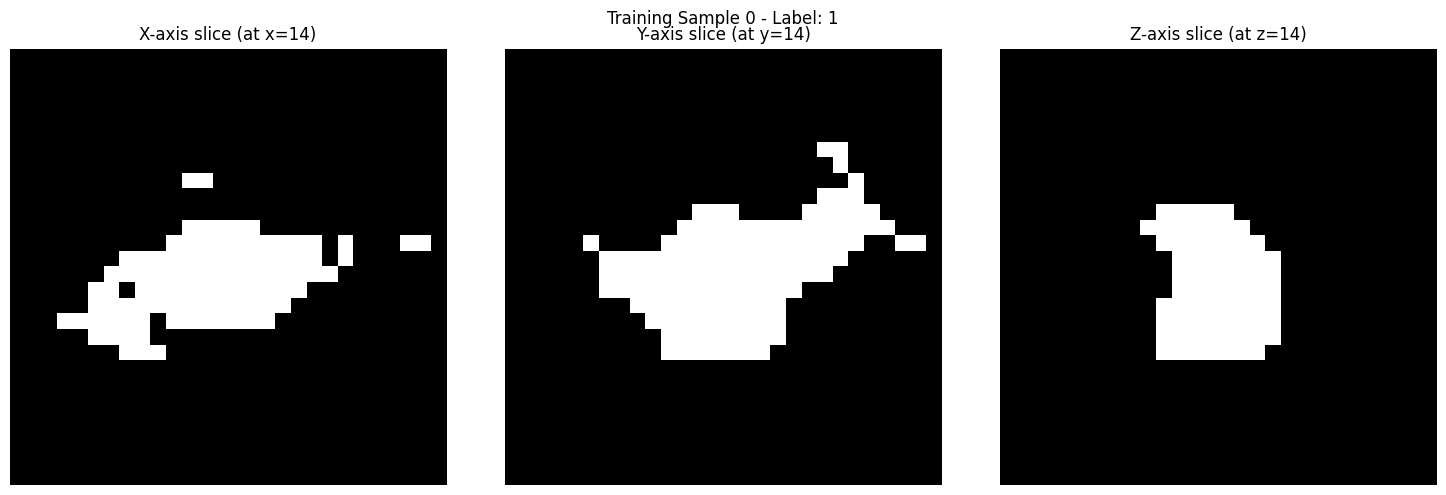

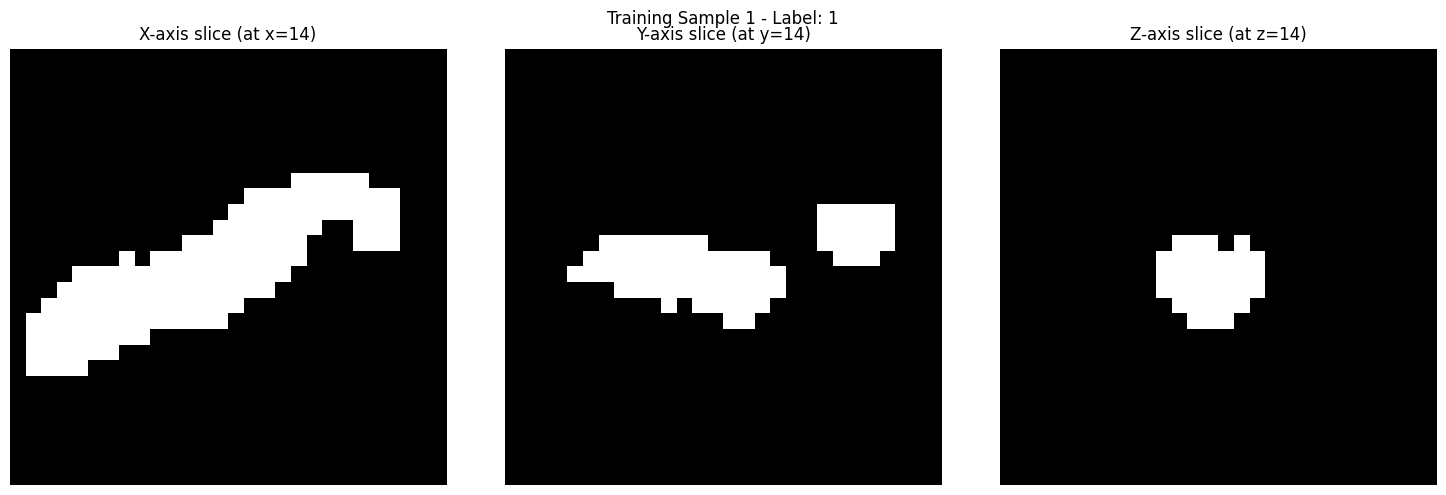


Building model...

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28,    │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augment3d_1         │ (None, 28, 28,    │          0 │ input_layer_1[0]… │
│ (Augment3D)         │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_29 (Conv3D)  │ (None, 28, 28,    │        448 │ augment3d_1[0][0] │
│                     │ 28, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ conv3d_29[0][0]   │
│ (BatchNormalizatio… │ 28, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_33 (Conv3D)  │ (None, 28, 28,    │        136 │ batch_normalizat… │
│                     │ 28, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_31 (Conv3D)  │ (None, 28, 28,    │        136 │ batch_normalizat… │
│                     │ 28, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_34 (Conv3D)  │ (None, 28, 28,    │      1,736 │ conv3d_33[0][0]   │
│                     │ 28, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 28, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_30 (Conv3D)  │ (None, 28, 28,    │        136 │ batch_normalizat… │
│                     │ 28, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_32 (Conv3D)  │ (None, 28, 28,    │      1,736 │ conv3d_31[0][0]   │
│                     │ 28, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_35 (Conv3D)  │ (None, 28, 28,    │      1,736 │ conv3d_34[0][0]   │
│                     │ 28, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_36 (Conv3D)  │ (None, 28, 28,    │        136 │ max_pooling3d_5[… │
│                     │ 28, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 28, 28,    │          0 │ conv3d_30[0][0],  │
│ (Concatenate)       │ 28, 32)           │            │ conv3d_32[0][0],  │
│                     │                   │            │ conv3d_35[0][0],  │
│                     │                   │            │ conv3d_36[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ concatenate_4[0]… │
│ (BatchNormalizatio… │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_37 (Conv3D)  │ (None, 28, 28,    │     27,680 │ dropout_6[0][0]   │
│                     │ 28, 32)           │            │                 

 Total params: 1,054,760 (4.02 MB)

 Trainable params: 1,052,584 (4.02 MB)

 Non-trainable params: 2,176 (8.50 KB)


Total trainable parameters: 1,052,584

Visualizing data augmentation effects...


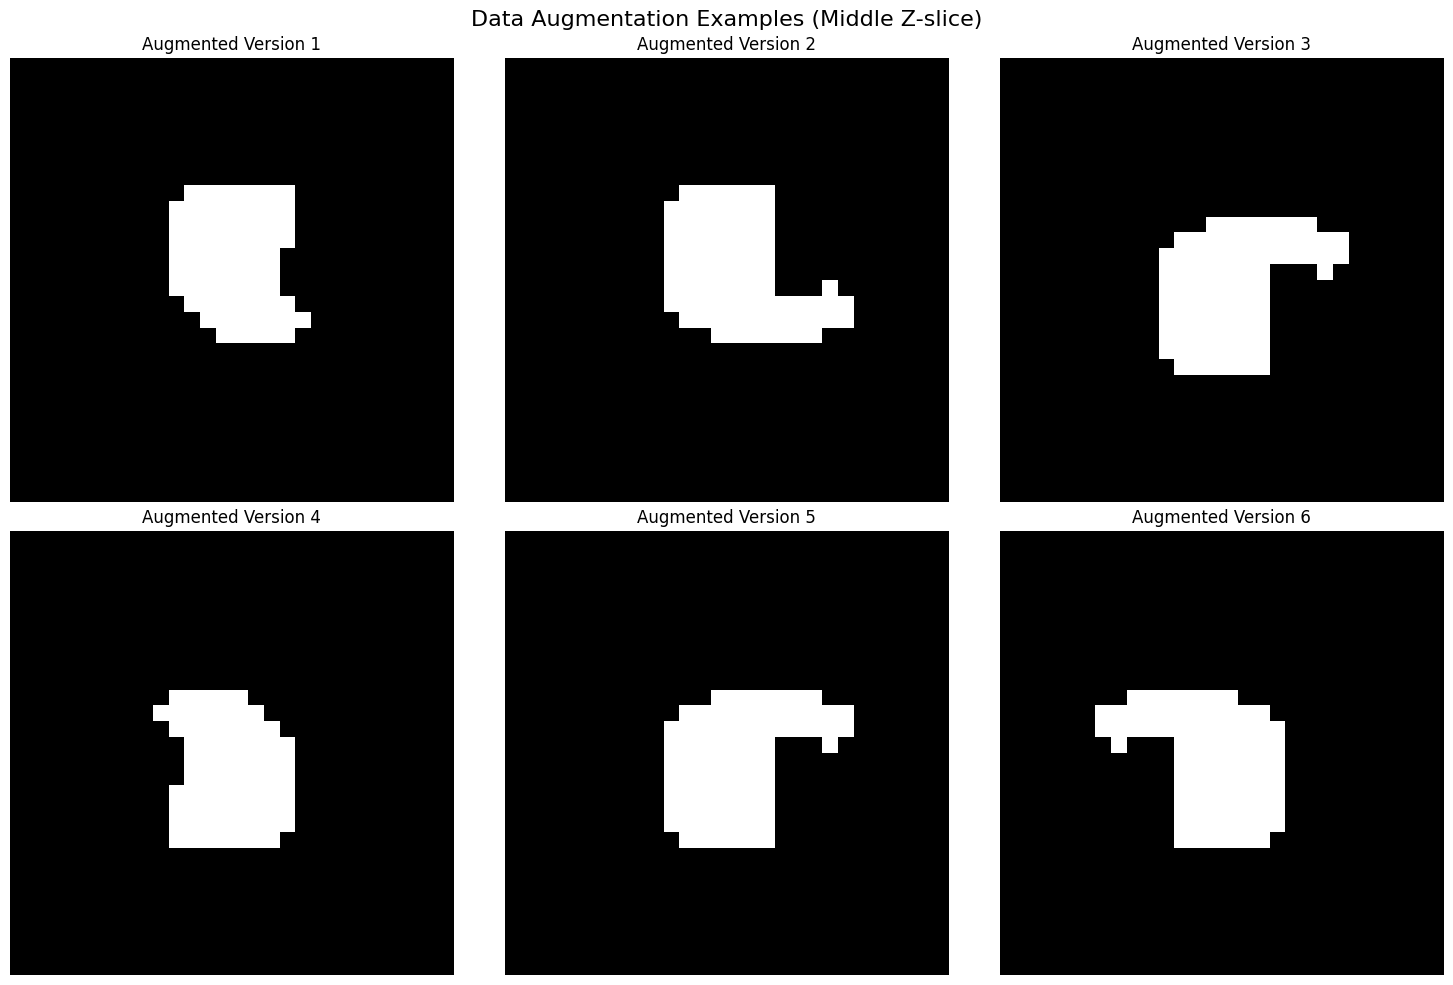


Starting training for 2 test epochs...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5100 - loss: 1.1973 - val_accuracy: 0.5600 - val_loss: 0.6883
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6000 - loss: 0.8429 - val_accuracy: 0.5600 - val_loss: 0.6888
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6300 - loss: 0.7731 - val_accuracy: 0.4400 - val_loss: 0.6996
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6700 - loss: 0.7806 - val_accuracy: 0.4400 - val_loss: 0.7373
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6900 - loss: 0.6484 - val_accuracy: 0.4400 - val_loss: 0.8298

Plotting training history...


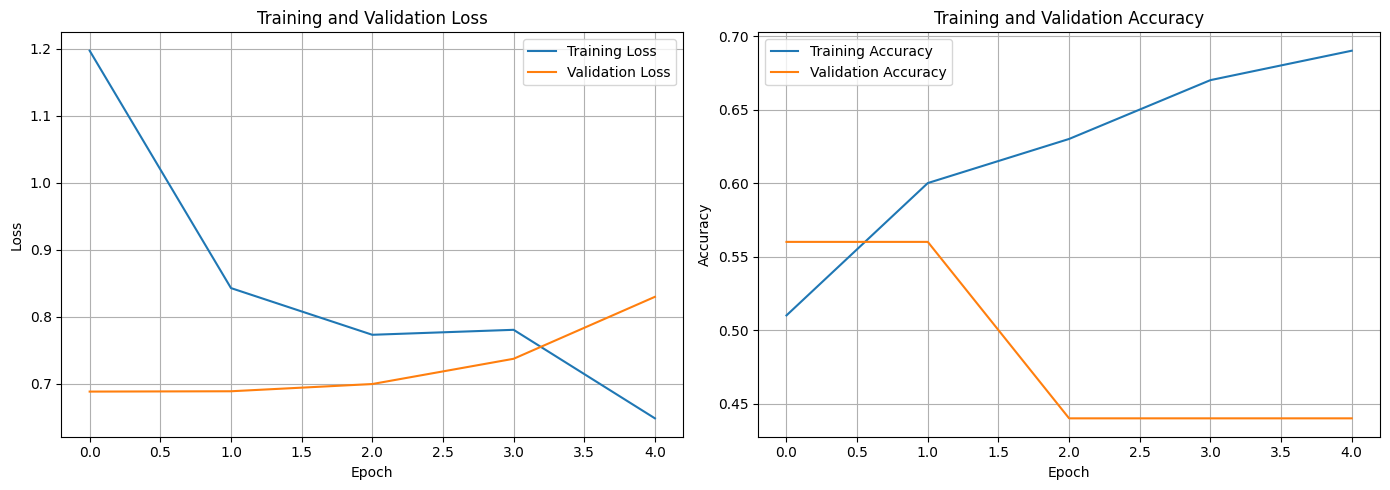


Evaluating on validation subset...
Validation Loss: 0.8298
Validation Accuracy: 0.4400

Making predictions on 5 validation samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Sample 0: True=1, Predicted=1, Confidence=0.6981
Sample 1: True=1, Predicted=1, Confidence=0.6989
Sample 2: True=1, Predicted=1, Confidence=0.6987
Sample 3: True=1, Predicted=1, Confidence=0.7009
Sample 4: True=1, Predicted=1, Confidence=0.6991

TEST COMPLETE!


In [ ]:
# #test 
# print("Running quick test...")
# model, history = quick_test_training()



Running full training...
FULL TRAINING SETUP (WITH 3D AUGMENTATION)
Loading VesselMNIST3D dataset...
Train: (1335, 28, 28, 28, 1), Labels: (1335,)
Val: (191, 28, 28, 28, 1), Labels: (191,)
Test: (382, 28, 28, 28, 1), Labels: (382,)
Number of classes: 2
Class distribution: [1185  150]

Training configuration:
- Training samples: 1335
- Validation samples: 191
- Test samples: 382
- Number of classes: 2
- Batch size: 32
- Max epochs: 100 (with early stopping)
- Augmentation: ENABLED (3D custom augmentation)

Starting full training...
Epoch 1/100


2025-12-11 16:36:49.336745: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 16:36:49.336770: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 16:36:49.336837: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 16:36:49.336845: I external/l

41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5573 - loss: 1.1504

2025-12-11 16:37:05.562807: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 16:37:05.562831: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 16:37:05.562853: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 16:37:05.562861: I external/l

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5578 - loss: 1.1464

2025-12-11 16:37:20.718924: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 16:37:20.718947: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 16:37:21.095948: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_811', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_accuracy improved from None to 0.88482, saving model to best_vesselmnist3d_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 533ms/step - accuracy: 0.5768 - loss: 0.9830 - val_accuracy: 0.8848 - val_loss: 0.6047 - learning_rate: 0.0010
Epoch 2/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6403 - loss: 0.6972
Epoch 2: val_accuracy did not improve from 0.88482
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6644 - loss: 0.6550 - val_accuracy: 0.8848 - val_loss: 0.3629 - learning_rate: 0.0010
Epoch 3/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7274 - loss: 0.5951
Epoch 3: val_accuracy did not improve from 0.88482
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7468 - loss: 0.5650 - val_accuracy: 0.8848 - val_loss: 0.5112 - learning_rate: 0.0010
Epoch 4/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7925 - loss: 0.4766
Epoch 4: val_accuracy did not improve from 0.88482
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7955 - loss: 0.4720 - val_accuracy: 0.8848 - val_loss: 0.6391 - learning_rate: 0.0010
Epoch 5/100
41/42 ━━━━━━━━━

2025-12-11 16:37:59.774737: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 16:37:59.774759: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 16:38:00.044899: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_811', 4 bytes spill stores, 4 bytes spill loads



12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.8874 - loss: 0.3583
Test Loss: 0.3583
Test Accuracy: 0.8874


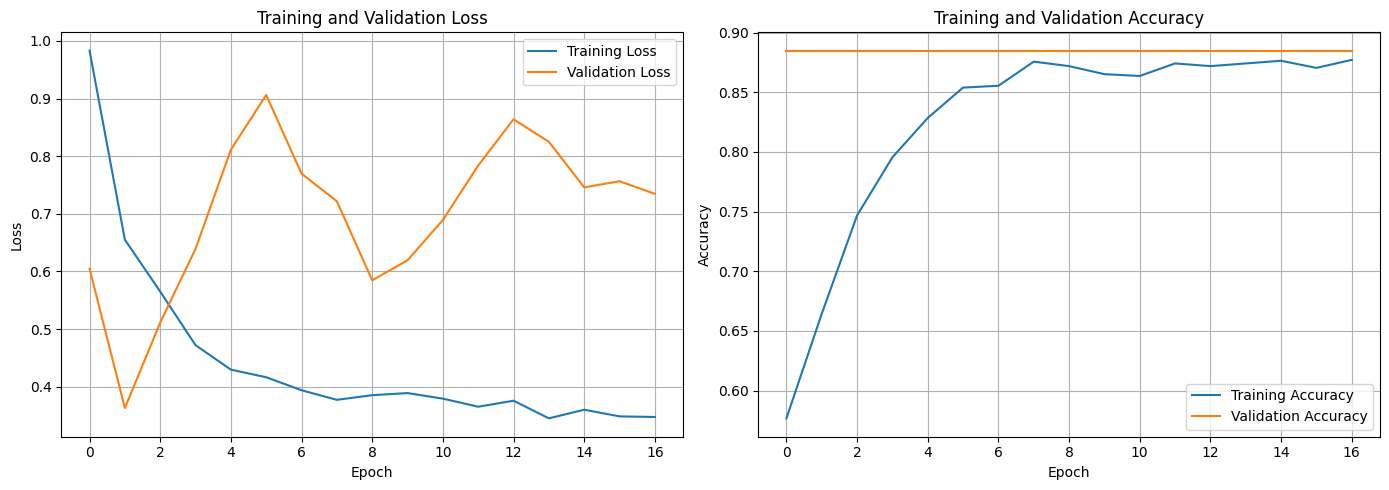

In [14]:
#Full training
print("Running full training...")
model, history = full_training_setup()

In [15]:
"""
Add this code to a new cell in your notebook after training completes
This will analyze the model's predictions in detail
"""

import numpy as np
from medmnist import VesselMNIST3D

# Load test data (same as what was used in training)
print("="*70)
print("DETAILED PREDICTION ANALYSIS")
print("="*70)

test_dataset = VesselMNIST3D(split='test', download=True)
test_images = test_dataset.imgs.astype('float32') / 255.0
test_labels = test_dataset.labels.squeeze()

# Add channel dimension if needed
if len(test_images.shape) == 4:
    test_images = np.expand_dims(test_images, axis=-1)

print(f"\nTest set size: {len(test_images)} samples")
print(f"Test set shape: {test_images.shape}")

# Get predictions
print("\nGenerating predictions...")
test_predictions = model.predict(test_images, verbose=0)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Prediction distribution
print("\n" + "="*70)
print("PREDICTION DISTRIBUTION")
print("="*70)
unique_preds, pred_counts = np.unique(test_pred_classes, return_counts=True)
print("\nWhat the model predicted:")
for cls, count in zip(unique_preds, pred_counts):
    print(f"  Class {cls}: {count} samples ({count/len(test_pred_classes)*100:.1f}%)")

# True label distribution
print("\n" + "="*70)
print("TRUE LABEL DISTRIBUTION")
print("="*70)
unique_true, true_counts = np.unique(test_labels, return_counts=True)
print("\nActual distribution in test set:")
for cls, count in zip(unique_true, true_counts):
    print(f"  Class {cls}: {count} samples ({count/len(test_labels)*100:.1f}%)")

# Per-class accuracy
print("\n" + "="*70)
print("PER-CLASS ACCURACY")
print("="*70)
for cls in unique_true:
    cls_mask = test_labels == cls
    cls_preds = test_pred_classes[cls_mask]
    cls_acc = np.mean(cls_preds == cls)
    n_samples = np.sum(cls_mask)
    print(f"  Class {cls}: {cls_acc*100:.1f}% accuracy ({int(cls_acc*n_samples)}/{n_samples} correct)")

# Confusion matrix breakdown
print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)
print("\nFormat: [True Class -> Predicted Class]: count")
for true_cls in unique_true:
    print(f"\nTrue Class {true_cls}:")
    for pred_cls in unique_true:
        count = np.sum((test_labels == true_cls) & (test_pred_classes == pred_cls))
        percentage = (count / np.sum(test_labels == true_cls)) * 100
        if count > 0:
            print(f"  -> Predicted as {pred_cls}: {count} samples ({percentage:.1f}%)")

# Overall metrics
correct = np.sum(test_pred_classes == test_labels)
total = len(test_labels)
accuracy = correct / total

print("\n" + "="*70)
print("OVERALL METRICS")
print("="*70)
print(f"Total correct: {correct}/{total}")
print(f"Overall accuracy: {accuracy*100:.2f}%")

# Check if model is just guessing majority class
majority_class = unique_true[np.argmax(true_counts)]
majority_percentage = np.max(true_counts) / len(test_labels) * 100
print(f"\nMajority class baseline: {majority_percentage:.2f}% (always predict class {majority_class})")

if accuracy * 100 <= majority_percentage + 5:
    print("\nWARNING: Model performance is close to majority class baseline!")
    print("The model may not be learning meaningful features.")
else:
    print("\nGood! Model performs better than majority class baseline.")

# Sample predictions with confidence scores
print("\n" + "="*70)
print("SAMPLE PREDICTIONS (first 20)")
print("="*70)
for i in range(min(20, len(test_images))):
    pred_class = test_pred_classes[i]
    true_class = test_labels[i]
    confidence = test_predictions[i][pred_class]
    correct_mark = "CORRECT" if pred_class == true_class else "WRONG"
    print(f"Sample {i:2d}: True={true_class}, Pred={pred_class}, "
          f"Confidence={confidence:.3f} [{correct_mark}]")

DETAILED PREDICTION ANALYSIS

Test set size: 382 samples
Test set shape: (382, 28, 28, 28, 1)

Generating predictions...

PREDICTION DISTRIBUTION

What the model predicted:
  Class 0: 382 samples (100.0%)

TRUE LABEL DISTRIBUTION

Actual distribution in test set:
  Class 0: 339 samples (88.7%)
  Class 1: 43 samples (11.3%)

PER-CLASS ACCURACY
  Class 0: 100.0% accuracy (339/339 correct)
  Class 1: 0.0% accuracy (0/43 correct)

CONFUSION MATRIX

Format: [True Class -> Predicted Class]: count

True Class 0:
  -> Predicted as 0: 339 samples (100.0%)

True Class 1:
  -> Predicted as 0: 43 samples (100.0%)

OVERALL METRICS
Total correct: 339/382
Overall accuracy: 88.74%

Majority class baseline: 88.74% (always predict class 0)

The model may not be learning meaningful features.

SAMPLE PREDICTIONS (first 20)
Sample  0: True=1, Pred=0, Confidence=0.850 [WRONG]
Sample  1: True=1, Pred=0, Confidence=0.849 [WRONG]
Sample  2: True=1, Pred=0, Confidence=0.851 [WRONG]
Sample  3: True=1, Pred=0, Co

In [16]:
"""
FIXED TRAINING SCRIPT - SOLVES CLASS IMBALANCE PROBLEM
Add this to your notebook and replace the full_training_setup() function
"""

import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Keep your existing Augment3D class and building blocks
# Just replace the full_training_setup function with this:

def full_training_setup_FIXED():
    """
    Fixed full training with proper class balancing
    """
    print("="*70)
    print("FULL TRAINING SETUP - WITH CLASS BALANCING FIX")
    print("="*70)
    
    # Load full dataset
    from medmnist import VesselMNIST3D
    
    train_dataset = VesselMNIST3D(split='train', download=True)
    val_dataset = VesselMNIST3D(split='val', download=True)
    test_dataset = VesselMNIST3D(split='test', download=True)
    
    train_images = train_dataset.imgs.astype('float32') / 255.0
    train_labels = train_dataset.labels.squeeze()
    
    val_images = val_dataset.imgs.astype('float32') / 255.0
    val_labels = val_dataset.labels.squeeze()
    
    test_images = test_dataset.imgs.astype('float32') / 255.0
    test_labels = test_dataset.labels.squeeze()
    
    # Add channel dimension
    if len(train_images.shape) == 4:
        train_images = np.expand_dims(train_images, axis=-1)
        val_images = np.expand_dims(val_images, axis=-1)
        test_images = np.expand_dims(test_images, axis=-1)
    
    # Analyze class distribution
    unique, counts = np.unique(train_labels, return_counts=True)
    print("\nClass distribution in training set:")
    for cls, count in zip(unique, counts):
        percentage = (count / len(train_labels)) * 100
        print(f"  Class {cls}: {count} samples ({percentage:.1f}%)")
    
    # CRITICAL: Compute class weights to handle imbalance
    class_weights_array = compute_class_weight(
        'balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
    
    print("\nComputed class weights to balance training:")
    for cls, weight in class_weights.items():
        print(f"  Class {cls}: weight = {weight:.3f}")
    
    # Build model (use your existing MyNet3D)
    num_classes = len(np.unique(train_labels))
    model = MyNet3D(num_classes=num_classes)
    
    # Add focal loss to help with imbalance (optional but helpful)
    # Focal loss focuses on hard examples
    def focal_loss(gamma=2.0, alpha=0.25):
        def loss_fn(y_true, y_pred):
            # Clip predictions to prevent log(0)
            y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
            
            # Convert labels to one-hot
            y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
            
            # Calculate focal loss
            cross_entropy = -y_true_one_hot * tf.math.log(y_pred)
            weight = alpha * tf.pow(1 - y_pred, gamma)
            focal_loss_value = weight * cross_entropy
            
            return tf.reduce_sum(focal_loss_value, axis=-1)
        return loss_fn
    
    # Recompile with focal loss (optional - comment out to use standard loss)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=focal_loss(gamma=2.0, alpha=0.25),  # Use focal loss
        # loss='sparse_categorical_crossentropy',  # Or use this with class_weight
        metrics=['accuracy']
    )
    
    # Setup callbacks
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        
        tf.keras.callbacks.ModelCheckpoint(
            'best_vesselmnist3d_BALANCED.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
    ]
    
    print("\nTraining configuration:")
    print(f"  Training samples: {len(train_images)}")
    print(f"  Validation samples: {len(val_images)}")
    print(f"  Test samples: {len(test_images)}")
    print(f"  Number of classes: {num_classes}")
    print(f"  Batch size: 32")
    print(f"  Max epochs: 100 (with early stopping)")
    print(f"  Augmentation: ENABLED")
    print(f"  Class weights: ENABLED (fixing imbalance)")
    print(f"  Loss function: Focal Loss (helps with imbalance)")
    
    # Train with class weights
    print("\nStarting training with class balancing...")
    print("="*70)
    
    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=100,
        batch_size=32,
        class_weight=class_weights,  # THIS IS CRITICAL
        callbacks=callbacks,
        verbose=1
    )
    
    # Final evaluation on test set
    print("\n" + "="*70)
    print("FINAL EVALUATION ON TEST SET")
    print("="*70)
    
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
    print(f"\nOverall Test Loss: {test_loss:.4f}")
    print(f"Overall Test Accuracy: {test_acc:.4f}")
    
    # Detailed per-class analysis
    print("\n" + "="*70)
    print("PER-CLASS PERFORMANCE ON TEST SET")
    print("="*70)
    
    test_predictions = model.predict(test_images, verbose=0)
    test_pred_classes = np.argmax(test_predictions, axis=1)
    
    print("\nPrediction distribution:")
    unique_preds, pred_counts = np.unique(test_pred_classes, return_counts=True)
    for cls, count in zip(unique_preds, pred_counts):
        print(f"  Predicted class {cls}: {count} samples ({count/len(test_pred_classes)*100:.1f}%)")
    
    print("\nPer-class accuracy:")
    for cls in unique:
        cls_mask = test_labels == cls
        cls_preds = test_pred_classes[cls_mask]
        cls_acc = np.mean(cls_preds == cls)
        n_samples = np.sum(cls_mask)
        n_correct = int(cls_acc * n_samples)
        print(f"  Class {cls}: {cls_acc*100:.1f}% accuracy ({n_correct}/{n_samples} correct)")
    
    # Check if model is still just predicting majority class
    majority_class = unique[np.argmax(counts)]
    majority_baseline = np.max(counts) / len(test_labels)
    
    print("\n" + "="*70)
    print("BASELINE COMPARISON")
    print("="*70)
    print(f"Majority class baseline: {majority_baseline*100:.2f}% (always predict class {majority_class})")
    print(f"Model accuracy: {test_acc*100:.2f}%")
    
    if test_acc > majority_baseline + 0.05:
        print("\nSUCCESS! Model is learning beyond majority class baseline.")
    else:
        print("\nWARNING: Model still close to majority class baseline.")
    
    return model, history

# Alternative: Use weighted sampling instead of class weights
def create_balanced_dataset(images, labels, batch_size=32):
    """
    Create a balanced dataset using weighted sampling
    This ensures each class appears equally often in each epoch
    """
    from sklearn.utils.class_weight import compute_sample_weight
    
    # Compute sample weights
    sample_weights = compute_sample_weight('balanced', labels)
    
    # Create tf.data.Dataset with sample weights
    dataset = tf.data.Dataset.from_tensor_slices((images, labels, sample_weights))
    dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

print("Fixed training function loaded!")
print("Run: model, history = full_training_setup_FIXED()")

Fixed training function loaded!
Run: model, history = full_training_setup_FIXED()


In [17]:
model, history = full_training_setup_FIXED()

FULL TRAINING SETUP - WITH CLASS BALANCING FIX

Class distribution in training set:
  Class 0: 1185 samples (88.8%)
  Class 1: 150 samples (11.2%)

Computed class weights to balance training:
  Class 0: weight = 0.563
  Class 1: weight = 4.450

Training configuration:
  Training samples: 1335
  Validation samples: 191
  Test samples: 382
  Number of classes: 2
  Batch size: 32
  Max epochs: 100 (with early stopping)
  Augmentation: ENABLED
  Class weights: ENABLED (fixing imbalance)
  Loss function: Focal Loss (helps with imbalance)

Starting training with class balancing...
Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.4591 - loss: 0.2484
Epoch 1: val_accuracy improved from None to 0.88482, saving model to best_vesselmnist3d_BALANCED.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 426ms/step - accuracy: 0.4891 - loss: 0.1991 - val_accuracy: 0.8848 - val_loss: 0.0710 - learning_rate: 0.0010
Epoch 2/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5552 - loss: 0.1209
Epoch 2: val_accuracy did not improve from 0.88482
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5588 - loss: 0.1111 - val_accuracy: 0.8848 - val_loss: 0.1101 - learning_rate: 0.0010
Epoch 3/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5390 - loss: 0.0976
Epoch 3: val_accuracy did not improve from 0.88482
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5536 - loss: 0.0987 - val_accuracy: 0.8848 - val_loss: 0.1901 - learning_rate: 0.0010
Epoch 4/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5809 - loss: 0.0901
Epoch 4: val_accuracy did not improve from 0.88482
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5798 - loss: 0.0894 - val_accuracy: 0.8848 - val_loss: 0.1798 - learning_rate: 0.0010
Epoch 5/100
41/42 ━━━━━━━━━

In [22]:
"""
AGGRESSIVE FIX FOR SEVERE CLASS IMBALANCE
Combines multiple techniques to force the model to learn both classes
"""

import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def balanced_batch_generator(images, labels, batch_size=32):
    """
    Generate balanced batches where each class appears equally
    This is the most effective way to handle severe imbalance
    """
    unique_classes = np.unique(labels)
    n_classes = len(unique_classes)
    samples_per_class = batch_size // n_classes
    
    # Ensure batch_size is even for 2 classes
    actual_batch_size = samples_per_class * n_classes
    
    # Group indices by class
    class_indices = {cls: np.where(labels == cls)[0] for cls in unique_classes}
    
    # Create infinite generator
    while True:
        batch_indices = []
        
        # Sample equally from each class
        for cls in unique_classes:
            indices = np.random.choice(
                class_indices[cls], 
                size=samples_per_class, 
                replace=True  # Allow repetition for minority class
            )
            batch_indices.extend(indices)
        
        # Shuffle within batch
        np.random.shuffle(batch_indices)
        
        # Ensure consistent batch size
        batch_images = images[batch_indices]
        batch_labels = labels[batch_indices]
        
        # Verify shape before yielding
        assert batch_images.shape[0] == actual_batch_size, f"Batch size mismatch: {batch_images.shape[0]} != {actual_batch_size}"
        
        yield batch_images, batch_labels

def full_training_AGGRESSIVE_FIX():
    """
    Most aggressive approach to fix class imbalance
    Uses balanced batch sampling + high class weights + focal loss
    """
    print("="*70)
    print("AGGRESSIVE CLASS IMBALANCE FIX")
    print("="*70)
    
    from medmnist import VesselMNIST3D
    
    # Load data
    train_dataset = VesselMNIST3D(split='train', download=True)
    val_dataset = VesselMNIST3D(split='val', download=True)
    test_dataset = VesselMNIST3D(split='test', download=True)
    
    train_images = train_dataset.imgs.astype('float32') / 255.0
    train_labels = train_dataset.labels.squeeze()
    
    val_images = val_dataset.imgs.astype('float32') / 255.0
    val_labels = val_dataset.labels.squeeze()
    
    test_images = test_dataset.imgs.astype('float32') / 255.0
    test_labels = test_dataset.labels.squeeze()
    
    if len(train_images.shape) == 4:
        train_images = np.expand_dims(train_images, axis=-1)
        val_images = np.expand_dims(val_images, axis=-1)
        test_images = np.expand_dims(test_images, axis=-1)
    
    # Analyze distribution
    unique, counts = np.unique(train_labels, return_counts=True)
    print("\nClass distribution:")
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count} samples ({count/len(train_labels)*100:.1f}%)")
    
    # Calculate extremely aggressive class weights
    # Give even MORE weight to minority class
    class_0_count = counts[0]
    class_1_count = counts[1]
    ratio = class_0_count / class_1_count
    
    # Aggressive weighting: 1.0 for majority, ratio^1.5 for minority
    class_weights = {
        0: 1.0,
        1: ratio ** 1.5  # Even more aggressive than balanced
    }
    
    print(f"\nAggressive class weights:")
    print(f"  Class 0: {class_weights[0]:.2f}")
    print(f"  Class 1: {class_weights[1]:.2f}")
    
    # Build model with your existing architecture
    num_classes = len(unique)
    model = MyNet3D(num_classes=num_classes)
    
    # Use standard loss with aggressive class weights
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    # Create balanced batch generators
    batch_size = 32
    # Make sure batch_size is even since we split equally between 2 classes
    if batch_size % 2 != 0:
        batch_size = 32  # Force to 32 (or any even number)
    
    steps_per_epoch = len(train_images) // batch_size
    val_steps = len(val_images) // batch_size
    
    print(f"\nBatch configuration:")
    print(f"  Batch size: {batch_size}")
    print(f"  Samples per class per batch: {batch_size // 2}")
    print(f"  Steps per epoch: {steps_per_epoch}")
    
    train_gen = balanced_batch_generator(train_images, train_labels, batch_size)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_recall',  # Monitor recall instead of accuracy
            mode='max',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        tf.keras.callbacks.EarlyStopping(
            monitor='val_recall',  # Focus on recall (finding minority class)
            mode='max',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        
        tf.keras.callbacks.ModelCheckpoint(
            'best_vesselmnist3d_AGGRESSIVE.h5',
            monitor='val_recall',  # Save based on recall
            mode='max',
            save_best_only=True,
            verbose=1
        ),
    ]
    
    print("\nTraining configuration:")
    print(f"  Method: BALANCED BATCH SAMPLING + AGGRESSIVE CLASS WEIGHTS")
    print(f"  Each batch has equal samples from both classes")
    print(f"  Minority class samples will be repeated")
    print(f"  Monitoring: Recall (ability to find minority class)")
    
    # Train with balanced batches AND class weights
    print("\n" + "="*70)
    print("Starting training...")
    print("="*70)
    
    # NOTE: Cannot use class_weight with generators
    # The balanced batch sampling handles class imbalance instead
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=(val_images, val_labels),
        epochs=100,
        callbacks=callbacks,
        verbose=1
    )
    
    # Detailed evaluation
    print("\n" + "="*70)
    print("FINAL EVALUATION")
    print("="*70)
    
    test_loss, test_acc, test_prec, test_recall = model.evaluate(
        test_images, test_labels, verbose=0
    )
    
    print(f"\nOverall Test Metrics:")
    print(f"  Accuracy:  {test_acc*100:.2f}%")
    print(f"  Precision: {test_prec*100:.2f}%")
    print(f"  Recall:    {test_recall*100:.2f}%")
    
    # Per-class analysis
    test_predictions = model.predict(test_images, verbose=0)
    test_pred_classes = np.argmax(test_predictions, axis=1)
    
    print("\n" + "="*70)
    print("PER-CLASS PERFORMANCE")
    print("="*70)
    
    # Prediction distribution
    unique_preds, pred_counts = np.unique(test_pred_classes, return_counts=True)
    print("\nPrediction distribution:")
    for cls, count in zip(unique_preds, pred_counts):
        print(f"  Predicted class {cls}: {count} samples ({count/len(test_pred_classes)*100:.1f}%)")
    
    # Per-class metrics
    print("\nPer-class accuracy:")
    for cls in unique:
        cls_mask = test_labels == cls
        cls_preds = test_pred_classes[cls_mask]
        cls_acc = np.mean(cls_preds == cls)
        n_samples = np.sum(cls_mask)
        n_correct = int(cls_acc * n_samples)
        print(f"  Class {cls}: {cls_acc*100:.1f}% ({n_correct}/{n_samples} correct)")
    
    # Confusion matrix
    print("\nConfusion Matrix:")
    for true_cls in unique:
        print(f"True Class {true_cls}:")
        for pred_cls in unique:
            count = np.sum((test_labels == true_cls) & (test_pred_classes == pred_cls))
            percentage = (count / np.sum(test_labels == true_cls)) * 100
            print(f"  -> Predicted as {pred_cls}: {count:3d} ({percentage:5.1f}%)")
    
    # Check improvement
    class_1_mask = test_labels == 1
    class_1_acc = np.mean(test_pred_classes[class_1_mask] == 1)
    
    print("\n" + "="*70)
    print("KEY METRIC: CLASS 1 (MINORITY) ACCURACY")
    print("="*70)
    print(f"Class 1 accuracy: {class_1_acc*100:.1f}%")
    
    if class_1_acc < 0.3:
        print("POOR: Model still struggles with minority class")
    elif class_1_acc < 0.5:
        print("FAIR: Some improvement but still needs work")
    elif class_1_acc < 0.7:
        print("GOOD: Reasonable performance on minority class")
    else:
        print("EXCELLENT: Strong performance on minority class")
    
    return model, history

# ALTERNATIVE: Data Augmentation for Minority Class Only
def augment_minority_class(images, labels, target_count):
    """
    Oversample minority class with augmentation to balance dataset
    """
    from scipy.ndimage import rotate, shift
    
    minority_mask = labels == 1
    minority_images = images[minority_mask]
    minority_labels = labels[minority_mask]
    
    current_count = len(minority_images)
    needed = target_count - current_count
    
    augmented_images = []
    augmented_labels = []
    
    for i in range(needed):
        # Pick random sample
        idx = np.random.randint(0, current_count)
        img = minority_images[idx].copy()
        
        # Random augmentation
        if np.random.rand() > 0.5:
            # Random rotation
            angle = np.random.uniform(-15, 15)
            img = rotate(img, angle, axes=(1, 2), reshape=False, mode='nearest')
        
        if np.random.rand() > 0.5:
            # Random shift
            shift_val = np.random.uniform(-2, 2, size=3)
            img = shift(img, shift=(shift_val[0], shift_val[1], shift_val[2], 0, 0), mode='nearest')
        
        if np.random.rand() > 0.5:
            # Random flip
            axis = np.random.choice([0, 1, 2])
            img = np.flip(img, axis=axis)
        
        augmented_images.append(img)
        augmented_labels.append(1)
    
    # Combine original and augmented
    balanced_images = np.concatenate([images, np.array(augmented_images)])
    balanced_labels = np.concatenate([labels, np.array(augmented_labels)])
    
    return balanced_images, balanced_labels

print("Aggressive fix loaded!")
print("Run: model, history = full_training_AGGRESSIVE_FIX()")

Aggressive fix loaded!
Run: model, history = full_training_AGGRESSIVE_FIX()


In [23]:
model, history = full_training_AGGRESSIVE_FIX()

AGGRESSIVE CLASS IMBALANCE FIX

Class distribution:
  Class 0: 1185 samples (88.8%)
  Class 1: 150 samples (11.2%)

Aggressive class weights:
  Class 0: 1.00
  Class 1: 22.20

Batch configuration:
  Batch size: 32
  Samples per class per batch: 16
  Steps per epoch: 41

Training configuration:
  Method: BALANCED BATCH SAMPLING + AGGRESSIVE CLASS WEIGHTS
  Each batch has equal samples from both classes
  Minority class samples will be repeated
  Monitoring: Recall (ability to find minority class)

Starting training...
Epoch 1/100


2025-12-11 16:50:13.450353: W tensorflow/core/framework/op_kernel.cc:1855] OP_REQUIRES failed at xla_ops.cc:590 : INVALID_ARGUMENT: Incompatible shapes: [1,32] vs. [1,64]
	 [[{{node LogicalAnd_1}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_489518[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
2025-12-11 16:50:13.450392: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [1,32] vs. [1,64]
	 [[{{node LogicalAnd_1}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_489518[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]]


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd_1 defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [1,32] vs. [1,64]
	 [[{{node LogicalAnd_1}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_489518[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_multi_step_on_iterator_490269]